# DeepOnet for guitar string

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [3]:
# finite-difference wave solver
def solve_wave(u0, c=1.0, nx=128, nt=100):
    dx = 1/(nx-1)
    dt = 0.5*dx  # stable CFL

    x = np.linspace(0,1,nx)
    t = np.linspace(0,1,nt)

    u = np.zeros((nt, nx))
    u[0] = u0

    # zero initial velocity
    u[1,1:-1] = u[0,1:-1] + (c*dt)**2/(dx**2) * \
        (u[0,2:] - 2*u[0,1:-1] + u[0,:-2])

    # time stepping
    for n in range(1, nt-1):
        u[n+1,1:-1] = (2*u[n,1:-1] - u[n-1,1:-1] +
                       (c*dt)**2/(dx**2) *
                       (u[n,2:] - 2*u[n,1:-1] + u[n,:-2]))

    return x, t, u


In [4]:
def random_initial_condition(nx, max_modes=6):
    x = torch.linspace(0, 1, nx, dtype=torch.float32)
    A = torch.randn(max_modes) * torch.exp(-0.3 * torch.arange(max_modes))
    u0 = sum(A[n] * torch.sin((n+1) * np.pi * x) for n in range(max_modes))
    return u0


def build_dataset(dataset_size=2000, nx=128, nt=100, max_modes=6):
    dataset = []
    for _ in range(dataset_size):
        u0 = random_initial_condition(nx, max_modes)
        _, _, sol = solve_wave(u0, nx=nx, nt=nt)  # sol is numpy array (nt, nx)
        dataset.append((u0, sol))
    return dataset


dataset = build_dataset(dataset_size=2000)

# Convert everything to torch.float32
dataset_u0 = torch.stack([u0.to(torch.float32) for u0, _ in dataset]).to(device)
dataset_sol = torch.stack([torch.tensor(sol, dtype=torch.float32) for _, sol in dataset]).to(device)

print(dataset_u0.shape, dataset_sol.shape)
print(dataset_u0.dtype, dataset_sol.dtype)


/tmp/ipykernel_196582/1755040737.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  u[0] = u0


torch.Size([2000, 128]) torch.Size([2000, 100, 128])
torch.float32 torch.float32


In [5]:
def create_training_batch_gpu(batch_size, N_samples):
    # pick random dataset entries
    idx = torch.randint(0, len(dataset_u0), (batch_size,), device=device)

    # (batch, nx)
    u0_batch = dataset_u0[idx]

    # random grid indices (batch, N_samples)
    ts = torch.randint(0, nt, (batch_size, N_samples), device=device)
    xs = torch.randint(0, nx, (batch_size, N_samples), device=device)

    # normalize coords for model input
    coords = torch.stack([
        ts.float() / (nt - 1),
        xs.float() / (nx - 1)
    ], dim=-1)  # (batch, N_samples, 2)

    # 1) select PDE solutions for each batch: (batch, nt, nx)
    sol_batch = dataset_sol[idx]    

    # 2) gather time values: (batch, N_samples, nx)
    sol_t = torch.gather(sol_batch, 1, ts.unsqueeze(-1).expand(-1, -1, nx))

    # 3) gather space values: (batch, N_samples)
    sol_tx = torch.gather(sol_t, 2, xs.unsqueeze(-1)).squeeze(-1)

    return u0_batch, coords, sol_tx


In [6]:
def fourier_features(coords, k=12):
    t = coords[:, 0:1]
    x = coords[:, 1:2]
    feats = [t, x]
    for n in range(1, k+1):
        feats.append(torch.sin(n * np.pi * t))
        feats.append(torch.cos(n * np.pi * t))
        feats.append(torch.sin(n * np.pi * x))
        feats.append(torch.cos(n * np.pi * x))
    return torch.cat(feats, dim=1)


In [7]:
class BranchNet(nn.Module):
    def __init__(self, nx=128, width=128, depth=4):
        super().__init__()
        layers = [nn.Linear(nx, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        self.net = nn.Sequential(*layers)

    def forward(self, u0):
        return self.net(u0)


In [8]:
class TrunkNet(nn.Module):
    def __init__(self, width=128, depth=5, k=6):
        super().__init__()
        self.k = k
        input_dim = 2 + 4 * k  # Fourier features: t, x, sin/cos up to k

        # First layer: SIREN (inject wave-like high-frequencies)
        self.fc_in = nn.Linear(input_dim, width)

        # Stable tanh layers with mild residuals
        self.layers = nn.ModuleList([
            nn.Linear(width, width) for _ in range(depth - 1)
        ])

        # Final basis function layer
        self.final = nn.Linear(width, width)

    def forward(self, coords):
        z = fourier_features(coords, self.k)

        # First SIREN activation
        h = torch.sin(self.fc_in(z))

        # Stable tanh layers with residual coefficient 0.5
        for layer in self.layers:
            h = h + 0.5 * torch.tanh(layer(h))

        return self.final(h)



class DeepONet(nn.Module):
    def __init__(self, nx=128, width=128, depth_branch=4, depth_trunk=5, k=6):
        super().__init__()
        self.branch = BranchNet(nx, width, depth_branch)
        self.trunk  = TrunkNet(width, depth_trunk, k)  # <-- IMPORTANT: k=6
        self.width = width

    def forward(self, u0, coords):
        B = self.branch(u0)                 # (batch, width)
        coords_flat = coords.view(-1, 2)    # (batch*N, 2)
        T = self.trunk(coords_flat)         # (batch*N, width)
        T = T.view(coords.shape[0], coords.shape[1], self.width)
        return (B.unsqueeze(1) * T).sum(-1)


In [9]:
# training loop
epochs      = 10000
batch_size  = 12
N_samples   = 3000
nx          = 128
nt          = 100
width       = 128

model = DeepONet(
    nx=nx,
    width=128,         # Lu et al. recommended
    depth_branch=4,    # Lu et al. recommended
    depth_trunk=5,     # Lu et al. recommended
    k=6                # Fourier features
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    u0, coords, target = create_training_batch_gpu(batch_size, N_samples)

    pred = model(u0, coords)
    loss = loss_fn(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4e}")


Epoch 0, Loss = 6.8887e-01
Epoch 200, Loss = 4.5643e-02
Epoch 400, Loss = 1.6082e-02
Epoch 600, Loss = 1.0719e-02
Epoch 800, Loss = 2.5735e-02
Epoch 1000, Loss = 1.7362e-02
Epoch 1200, Loss = 1.6839e-02
Epoch 1400, Loss = 4.1633e-03
Epoch 1600, Loss = 9.6375e-03
Epoch 1800, Loss = 1.6071e-02
Epoch 2000, Loss = 1.1547e-02
Epoch 2200, Loss = 1.3906e-02
Epoch 2400, Loss = 5.3825e-03
Epoch 2600, Loss = 6.7080e-03
Epoch 2800, Loss = 1.2280e-02
Epoch 3000, Loss = 5.7010e-03
Epoch 3200, Loss = 1.1508e-02
Epoch 3400, Loss = 5.3425e-03
Epoch 3600, Loss = 3.8550e-03
Epoch 3800, Loss = 5.8217e-03
Epoch 4000, Loss = 5.7172e-03
Epoch 4200, Loss = 2.9859e-03
Epoch 4400, Loss = 3.6937e-03
Epoch 4600, Loss = 8.8609e-03
Epoch 4800, Loss = 4.9492e-03
Epoch 5000, Loss = 5.1844e-03
Epoch 5200, Loss = 3.8601e-03
Epoch 5400, Loss = 1.5295e-02
Epoch 5600, Loss = 1.6267e-03
Epoch 5800, Loss = 7.0393e-03
Epoch 6000, Loss = 1.6915e-02
Epoch 6200, Loss = 4.9546e-03
Epoch 6400, Loss = 4.5233e-03
Epoch 6600, Loss 

/tmp/ipykernel_196582/420812483.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_pred = model(torch.tensor(u0).float().to(device).unsqueeze(0), coords_t)


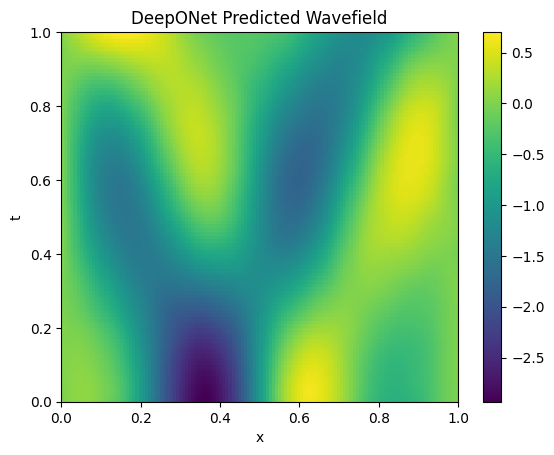

In [10]:
def predict_solution(model, u0, nx=128, nt=100):
    x = np.linspace(0,1,nx)
    t = np.linspace(0,1,nt)
    coords = np.stack(np.meshgrid(t, x, indexing='ij'), axis=-1).reshape(-1,2)
    coords_t = torch.tensor(coords, dtype=torch.float32).to(device).unsqueeze(0)
    u_pred = model(torch.tensor(u0).float().to(device).unsqueeze(0), coords_t)
    return u_pred.view(nt, nx).detach().cpu().numpy()

# test a random initial condition
u0_test = random_initial_condition(nx)
u_pred = predict_solution(model, u0_test)

plt.imshow(u_pred, extent=[0,1,0,1], aspect='auto', origin='lower')
plt.xlabel("x")
plt.ylabel("t")
plt.title("DeepONet Predicted Wavefield")
plt.colorbar()
plt.show()


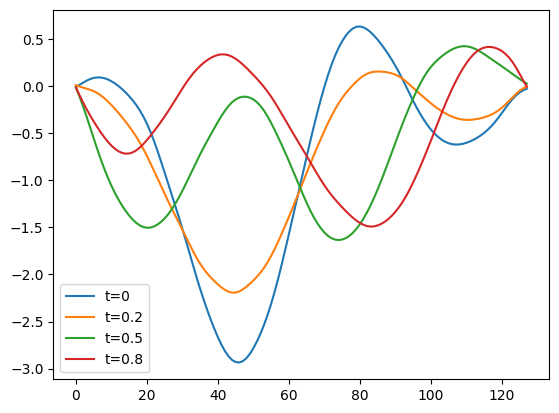

In [24]:
plt.plot(u_pred[0], label="t=0")
plt.plot(u_pred[20], label="t=0.2")
plt.plot(u_pred[50], label="t=0.5")
plt.plot(u_pred[80], label="t=0.8")
plt.legend()
plt.show()


/tmp/ipykernel_196582/3059868810.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


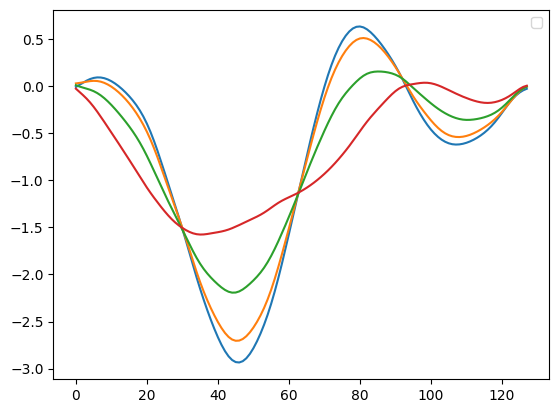

In [25]:
t_diff_evolution=10
plt.plot(u_pred[0])
plt.plot(u_pred[t_diff_evolution])
plt.plot(u_pred[2*t_diff_evolution])
plt.plot(u_pred[3*t_diff_evolution])
plt.legend()
plt.show()